# Functional EDeN for RNA

Using functional coding style with the Explicit Decomposition with Neighborhoods vectorizer

`jupyter nbconvert rna/multiclass_RNA.ipynb --to slides --post serve`

In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from toolz import curry, compose, map, concat, pipe

In [3]:
# import RNA sequences
from eden_rna.io.rfam import load
load_rfam = lambda num_seqs, rfam_id: load(rfam_id, seq_ids=range(num_seqs))
cload_rfam = curry(load_rfam)(400)

In [4]:
# map graphs to vectors
from eden.graph import vectorize
cvectorize = curry(vectorize)(complexity=3, nbits=16)

In [5]:
import random

def shuffle(sequence, times=None, order=None):
    header, seq = sequence
    for i in range(times):
        kmers = [seq[i:i + order] for i in range(0, len(seq), order)]
        random.shuffle(kmers)
        seq_out = ''.join(kmers)
        yield header, seq_out
        
cshuffle = curry(shuffle)(times=1, order=2)
make_negative = compose(concat, curry(map)(cshuffle))

In [6]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier

def make_data(cfold, rfam_ids):
    vec_fold_rfam_id = compose(cvectorize, cfold, cload_rfam)
    data_list = list(map(vec_fold_rfam_id, rfam_ids))
    class_X = vstack(data_list)
    class_y = list(concat([[i]*data.shape[0] 
                           for i, data in enumerate(data_list, start=1)]))

    neg_vec_fold_rfam_id = compose(cvectorize, cfold, make_negative,cload_rfam)
    neg_data_list = list(map(neg_vec_fold_rfam_id, rfam_ids))
    neg_X = vstack(neg_data_list)
    neg_y = list(concat([[0]*data.shape[0] for data in neg_data_list]))
    
    X = vstack((neg_X, class_X))
    y = np.array(neg_y + class_y)
    return X, y

In [7]:
from eden_rna.rnafold import fold
cmake_data = curry(make_data)(fold)

In [8]:
import numpy as np
from scipy.sparse import vstack
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

def predictive_performance(data):
    X, y = data
    predictor = SGDClassifier(average=True, 
                              class_weight='balanced', 
                              shuffle=True, 
                              n_jobs=-1)
    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
    scoring = make_scorer(accuracy_score)
    scores = cross_val_score(predictor, X, y, cv=cv, scoring=scoring)
    return scores

def output_avg_and_std(scores):
    print('Acc: %.4f +- %.4f' % (np.mean(scores),np.std(scores)))

In [9]:
rfam_ids = ['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
            'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
            'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
            'RF01942','RF01998','RF02005','RF02012','RF02034']
rfam_ids = rfam_ids[0:7]

In [10]:
%%time
pipe(rfam_ids, cmake_data, predictive_performance, output_avg_and_std)

Acc: 0.9535 +- 0.0049
CPU times: user 2min 43s, sys: 14.7 s, total: 2min 58s
Wall time: 4min 29s


---

In [11]:
#fold sequence into a structure graph


# alternatives:
#sequence
from eden_rna.sequence import fold
cfold = fold

#RNAplfold
from eden_rna.rnaplfold import fold
plfold_params = dict(window_size = 250,
                     max_bp_span = 150,
                     hard_threshold=0.5,
                     avg_bp_prob_cutoff = 0.3,
                     max_num_edges = 2,
                     no_lonely_bps=True,
                     nesting=True)
cfold = curry(fold)(**plfold_params)

# RNAfold
from eden_rna.rnafold import fold
cfold = fold

In [12]:
def split(sequence, step=1, window=20):
    header, seq = sequence
    seq_len = len(seq)
    for start in range(0, seq_len, step):
        seq_out = seq[start: start + window]
        if len(seq_out) == window:
            end = int(start + len(seq_out))
            header_out = '%s_%d:%d' % (header, start, end)
            yield (header_out, seq_out)

csplit = curry(split)(step=10, window=30)
csplit_seqs = curry(map)(csplit)

from networkx import disjoint_union
union_redux = lambda graphs: reduce(disjoint_union, graphs, graphs.next())

def windowed_fold(cfold, seqs):
    for windows in csplit_seqs(seqs):
        graphs = cfold(windows)
        yield union_redux(graphs)

cwindowed_fold = curry(windowed_fold)(cfold)

$x = \sum_i X$

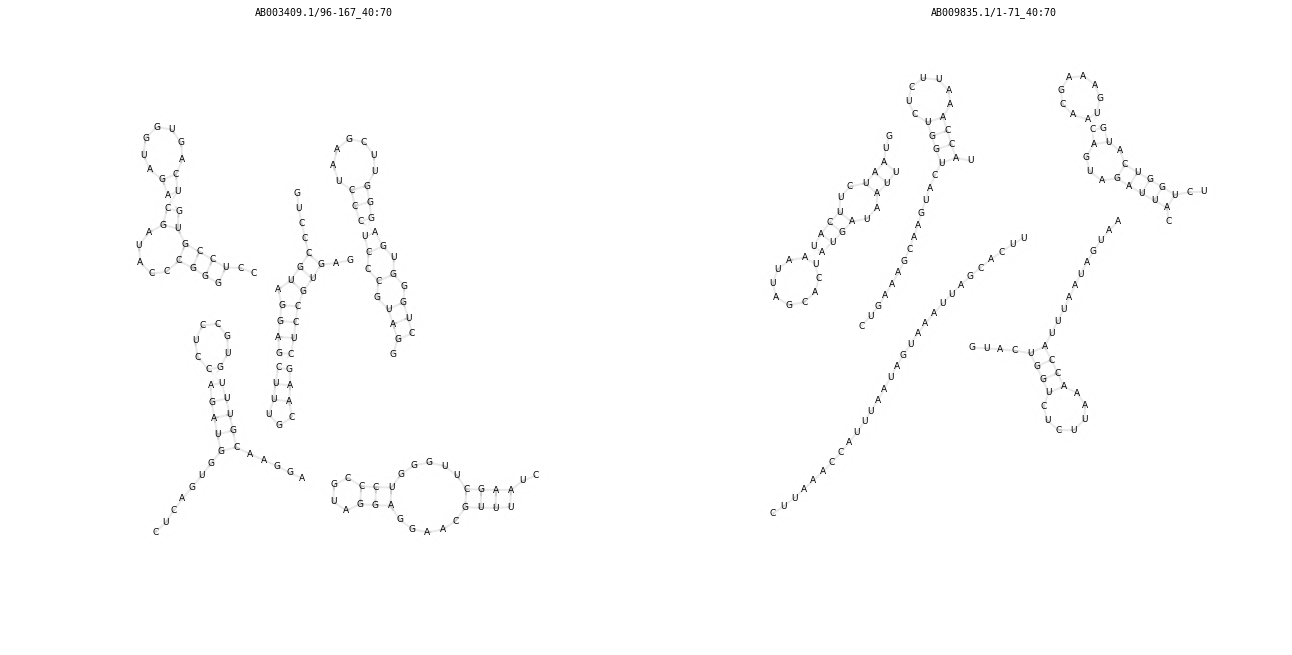

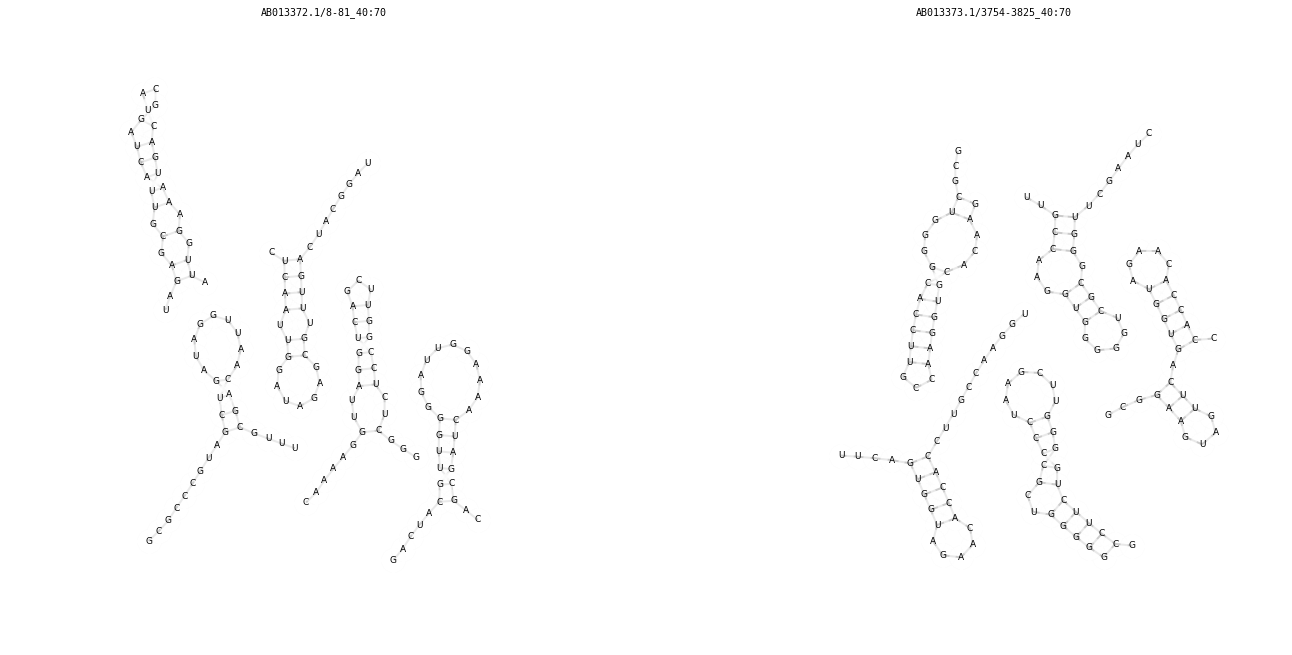

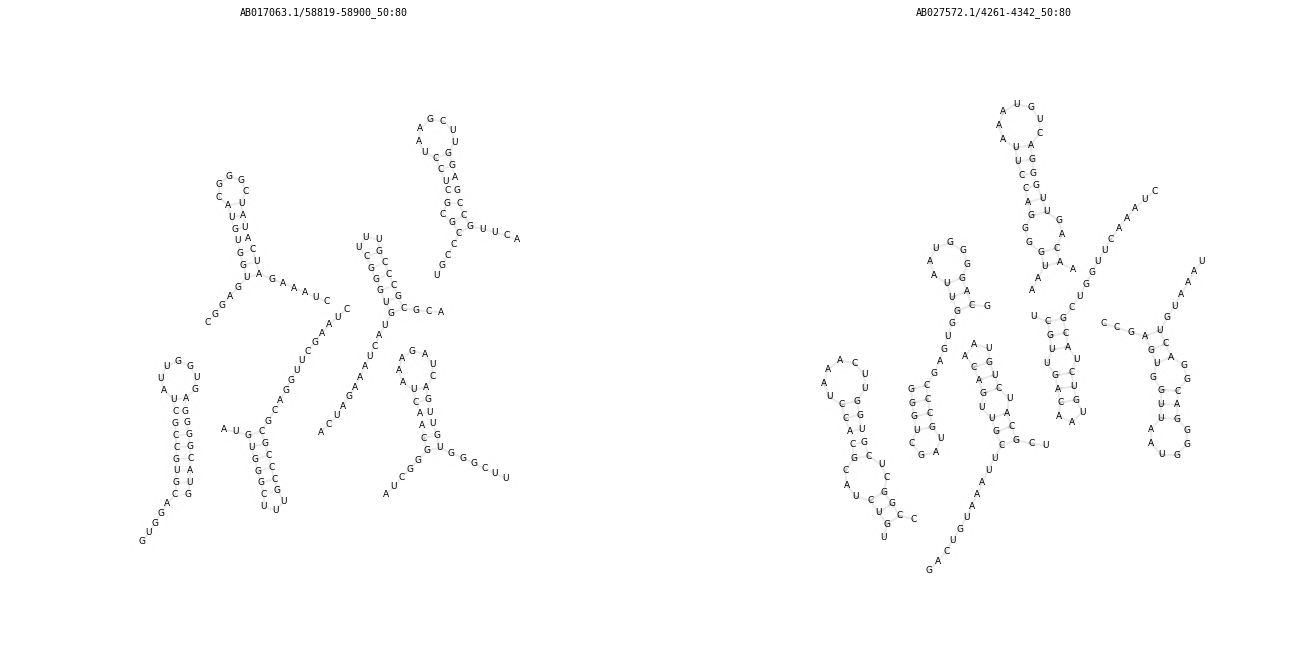

In [13]:
seqs = load_rfam(6, 'RF00005')
graphs = cwindowed_fold(seqs)

from eden.display import draw_graph_set
draw_graph_set(graphs, n_graphs_per_line=2, size=11)

---

In [14]:
cmake_data = curry(make_data)(cwindowed_fold)

In [15]:
%%time
pipe(rfam_ids, cmake_data, predictive_performance, output_avg_and_std)

Acc: 0.9493 +- 0.0077
CPU times: user 6min 29s, sys: 1min 32s, total: 8min 1s
Wall time: 13min 33s


In [16]:
from eden.display import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
    
def evaluate_confusion_matrix(data):
    X, y = data
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.33, 
                                                        random_state=42)
    predictor = SGDClassifier(average=True, 
                              class_weight='balanced', 
                              shuffle=True, 
                              n_jobs=-1)
    predictor.fit(X_train, y_train)
    preds = predictor.predict(X_test)

    print 'Classification Report:'
    print classification_report(y_test, preds)
    
    plot_confusion_matrix(y_test, preds, size=7, normalize=False)
    plot_confusion_matrix(y_test, preds, size=7 ,normalize=True)

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.97      0.95       492
          1       1.00      0.94      0.97        69
          2       0.88      0.89      0.88       129
          3       1.00      0.89      0.94        47
          4       1.00      0.94      0.97        68
          5       1.00      0.98      0.99        54
          6       0.96      0.93      0.95        58
          7       1.00      1.00      1.00        48

avg / total       0.95      0.95      0.95       965



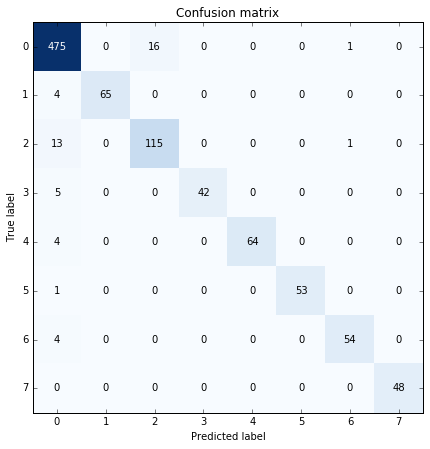

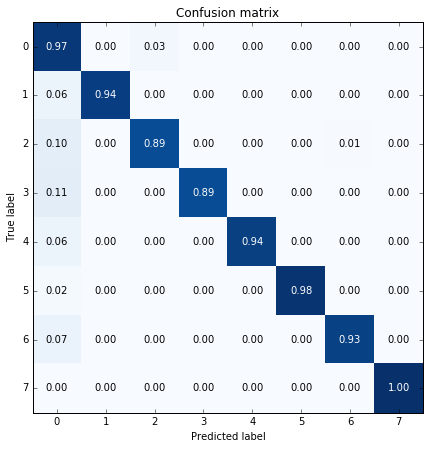

CPU times: user 3min 53s, sys: 1min 30s, total: 5min 24s
Wall time: 13min 2s


In [17]:
%%time
pipe(rfam_ids, cmake_data, evaluate_confusion_matrix)

---